## 2910 - Full tank updated dataset

In [1]:
# Python library and module imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
import h5py
import torch

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# Import the custom plotting module
from plot_utils import plot_utils

# WatChMaL imports
from io_utils.data_handling_2 import WCH5Dataset

# PyTorch imports
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from collections import Counter 

In [2]:
path = "/fast_scratch/IWCDmPMT_4pi_fulltank_9M.h5"
f = h5py.File(path, 'r')

In [3]:
f.keys()

<KeysViewHDF5 ['angles', 'energies', 'event_data', 'event_ids', 'labels', 'positions', 'root_files']>

In [4]:
train_batch_size = 1024

In [5]:
dset=WCH5Dataset(path, 0.1, 0.1, reduced_dataset_size=100000)

In [6]:
train_loader = DataLoader(dset, batch_size=train_batch_size, shuffle=False,
                          num_workers=4, sampler=SubsetRandomSampler(dset.train_indices))

### Iterate over the dataset and collect the samples

In [7]:
event_charges = []
event_timings = []

labels = []

for data in iter(train_loader):
    event_charges.append(data[0][:,:,:,:19].numpy())
    event_timings.append(data[0][:,:,:,19:].numpy())
    
    labels.append(data[1].numpy())

In [8]:
print(len(event_charges), event_charges[0].shape, len(event_timings), event_timings[0].shape)

79 (1024, 40, 40, 19) 79 (1024, 40, 40, 19)


In [9]:
print(len(labels), labels[0].shape)

79 (1024,)


### Reshape the multi-dimensional arrays into shape = (num_examples, *)

In [10]:
event_charges = np.concatenate(event_charges, axis=0)
event_timings = np.concatenate(event_timings, axis=0)

In [11]:
labels = np.concatenate(labels, axis=0)

In [12]:
print(event_charges.shape, event_timings.shape, labels.shape)

(80000, 40, 40, 19) (80000, 40, 40, 19) (80000,)


### Plot the distrbutions of the features from the dataset

In [13]:
print(Counter(labels))

Counter({0: 26986, 1: 26676, 2: 26338})


In [14]:
label_dict = {0:["gamma","red"], 1:["e","blue"], 2:["mu","green"]}

### Plot the per label per PMT charge distribution

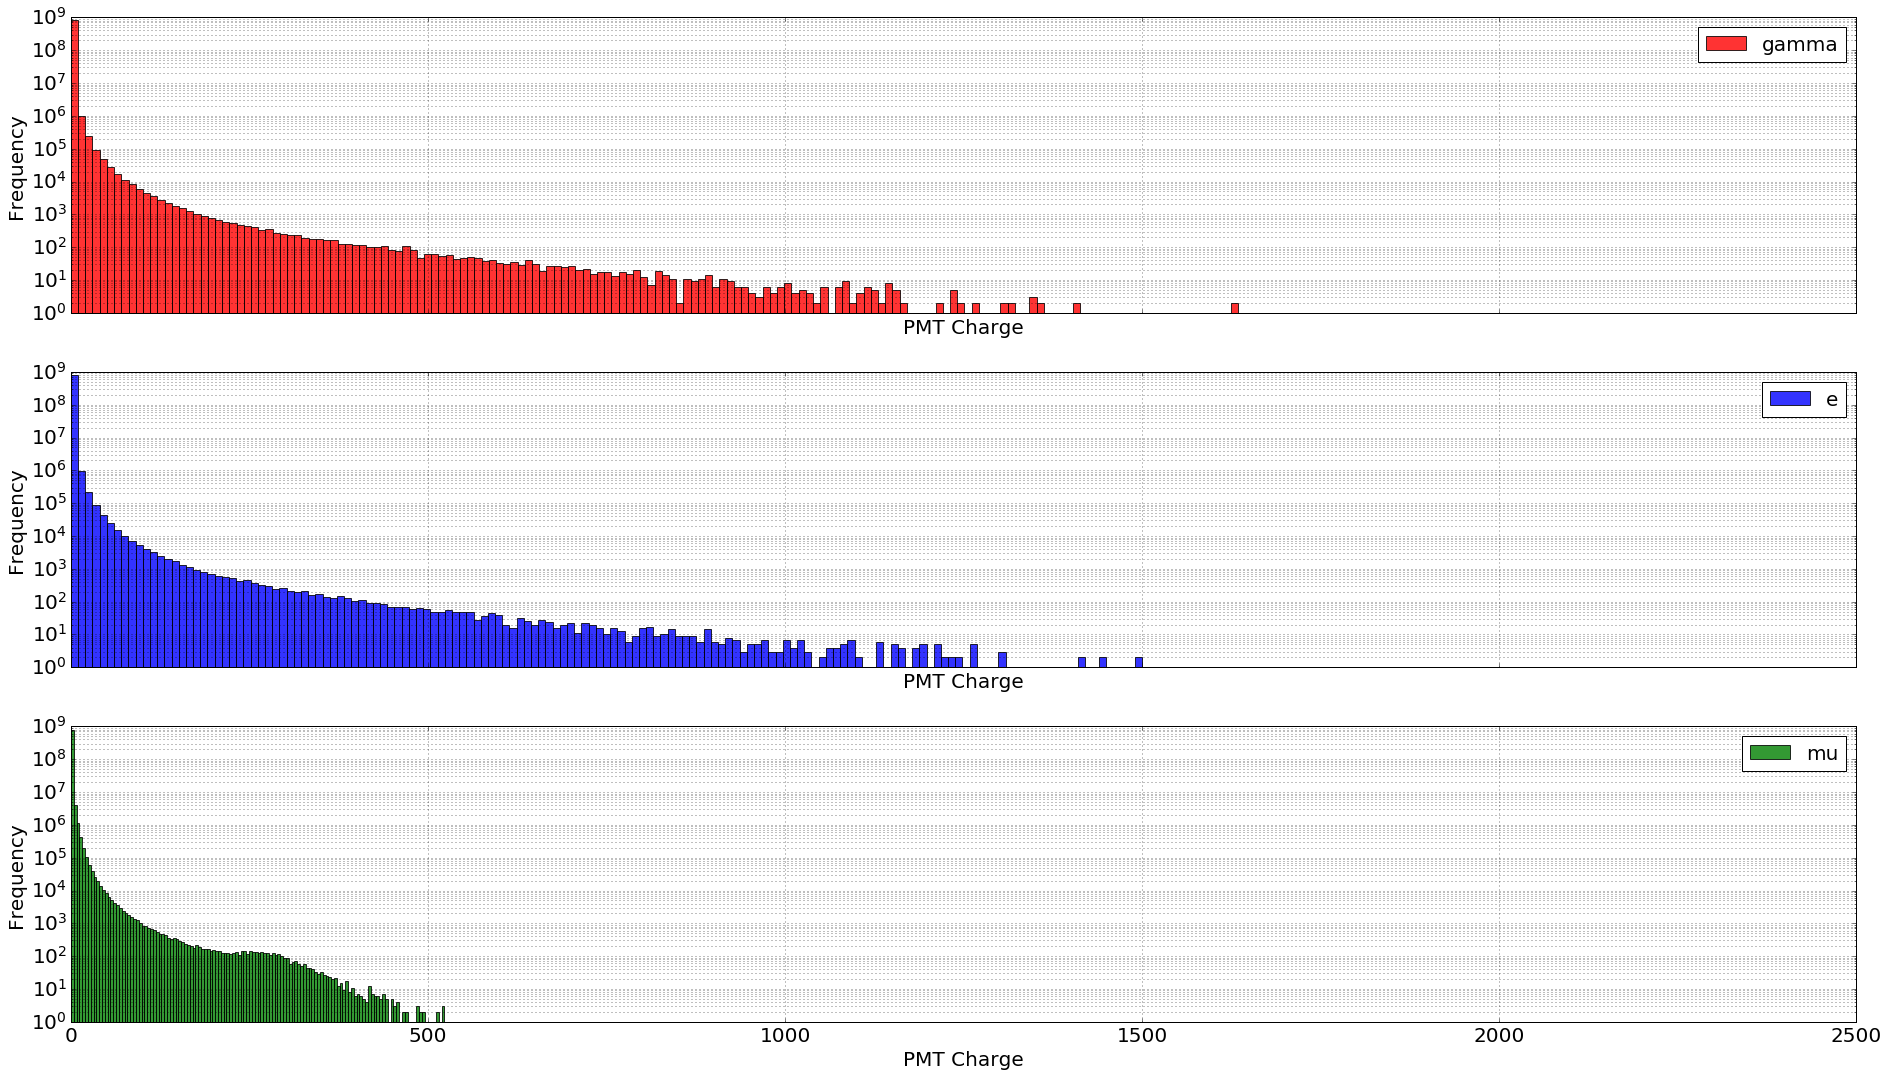

In [18]:
event_charge_dict = {}
for label in label_dict.keys():
    event_charge_dict[label] = event_charges[labels == label].flatten()
    
fig, axes = plt.subplots(3, 1, figsize=(32,18), sharex=True)

for label in label_dict.keys():
    axes[label].hist(event_charge_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend(prop={"size":20})
    axes[label].set_xlabel("PMT Charge", fontsize=20)
    axes[label].set_ylabel("Frequency", fontsize=20)
    axes[label].tick_params(axis="both", labelsize=20)
    axes[label].set_yscale("log")
    axes[label].grid(True, which="both", axis="both")

### Plot the per label per PMT timing distribution

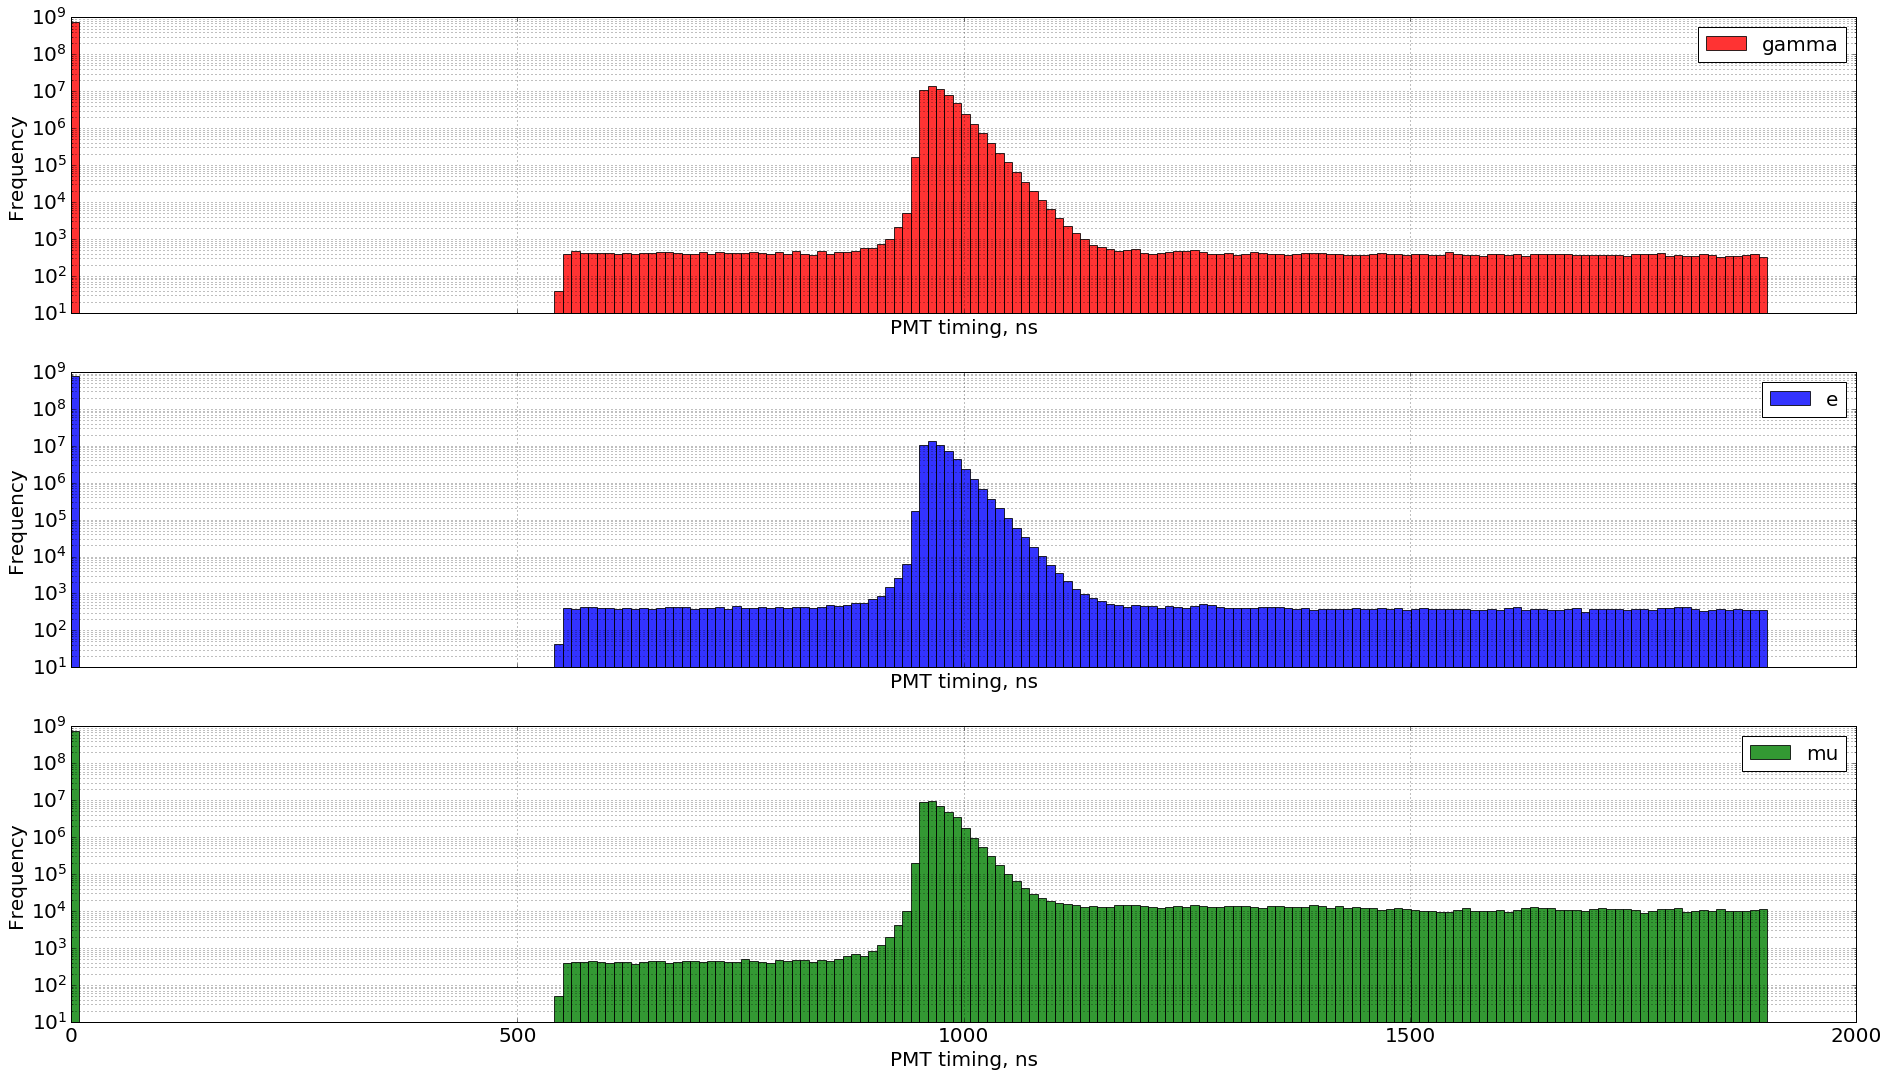

In [19]:
event_timing_dict = {}
for label in label_dict.keys():
    event_timing_dict[label] = event_timings[labels == label].flatten()
    
fig, axes = plt.subplots(3, 1, figsize=(32,18), sharex=True)

for label in label_dict.keys():
    axes[label].hist(event_timing_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend(prop={"size":20})
    axes[label].set_xlabel("PMT timing, ns", fontsize=20)
    axes[label].set_ylabel("Frequency", fontsize=20)
    axes[label].tick_params(axis="both", labelsize=20)
    axes[label].set_yscale("log")
    axes[label].grid(True, which="both", axis="both")

### Did not read positions from data. Instead of reading using the dataloader, read the positions raw

In [20]:
raw_positions = np.array(f["positions"])
raw_labels    = np.array(f["labels"])
raw_energies  = np.array(f["energies"])
raw_angles    = np.array(f["angles"])

In [21]:
print(raw_positions.shape, raw_labels.shape, raw_energies.shape, raw_angles.shape)

(8834960, 1, 3) (8834960,) (8834960, 1) (8834960, 2)


In [22]:
raw_positions = raw_positions.reshape(-1, 3)
raw_labels    = raw_labels.reshape(-1)
raw_energies  = raw_energies.reshape(-1)
raw_angles    = raw_angles.reshape(-1, 2)

Text(0.5, 0, 'Energy (MeV)')

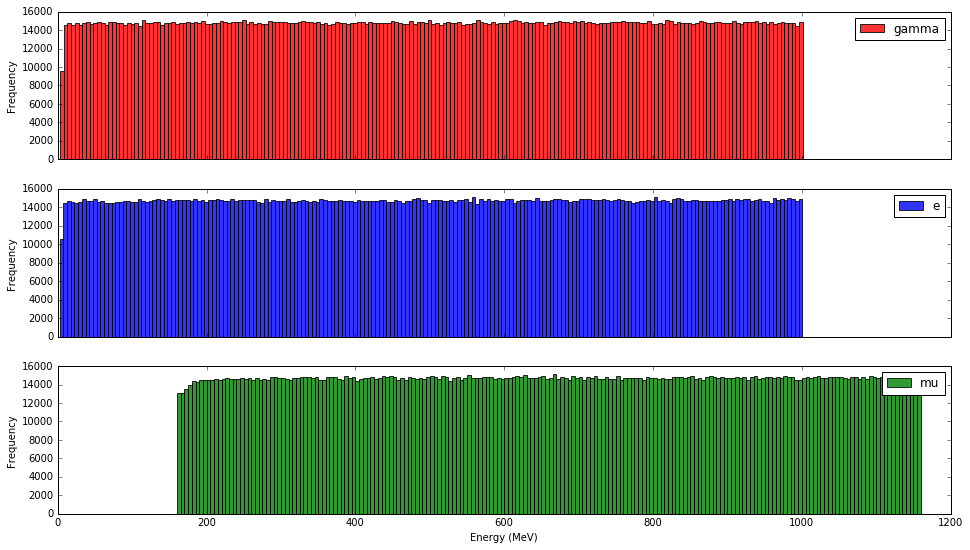

In [23]:
energies_dict = {}
for label in label_dict.keys():
    energies_dict[label] = raw_energies[raw_labels == label]

fig, axes = plt.subplots(3, 1, figsize=(16,9), sharex=True)

for label in energies_dict.keys():
    axes[label].hist(energies_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend()
    axes[label].set_ylabel("Frequency")
    
plt.xlabel("Energy (MeV)")

Text(0.5, 0, 'Angle at index 0')

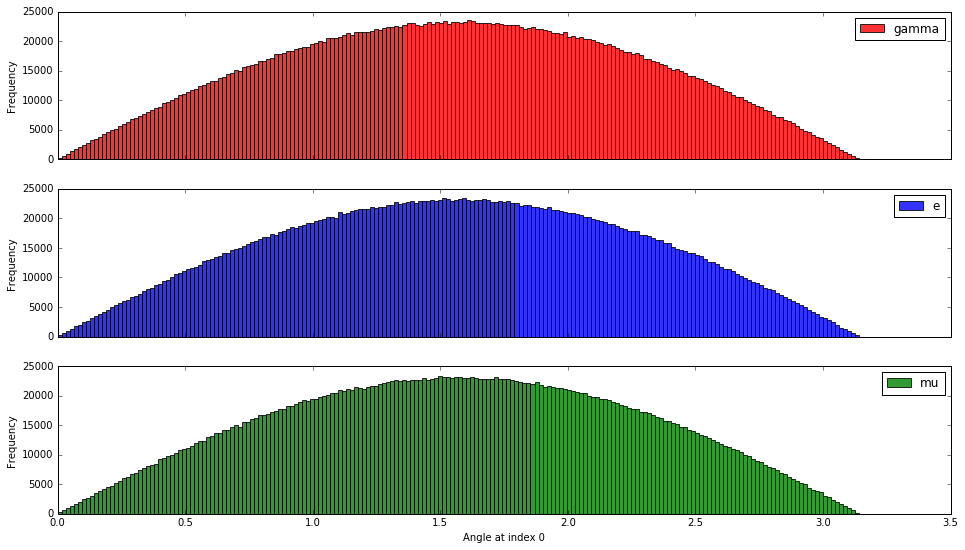

In [24]:
angles_0_dict = {}
for label in label_dict.keys():
    angles_0_dict[label] = raw_angles[raw_labels == label][:,0]
    
fig, axes = plt.subplots(3, 1, figsize=(16,9), sharex=True)

for label in angles_0_dict.keys():
    axes[label].hist(angles_0_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend()
    axes[label].set_ylabel("Frequency")
    
plt.xlabel("Angle at index 0")

Text(0.5, 0, 'Angle at index 1')

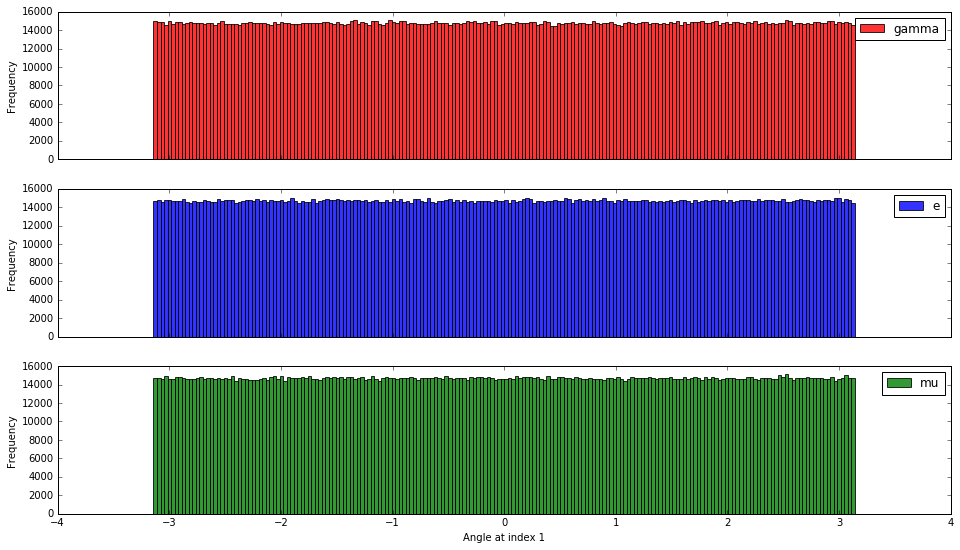

In [25]:
angles_1_dict = {}
for label in label_dict.keys():
    angles_1_dict[label] = raw_angles[raw_labels == label][:,1]
    
fig, axes = plt.subplots(3, 1, figsize=(16,9), sharex=True)

for label in angles_1_dict.keys():
    axes[label].hist(angles_1_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend()
    axes[label].set_ylabel("Frequency")
    
plt.xlabel("Angle at index 1")

Text(0.5, 0, 'Position, $r = \\sqrt{x^2 + y^2 + z^2}$')

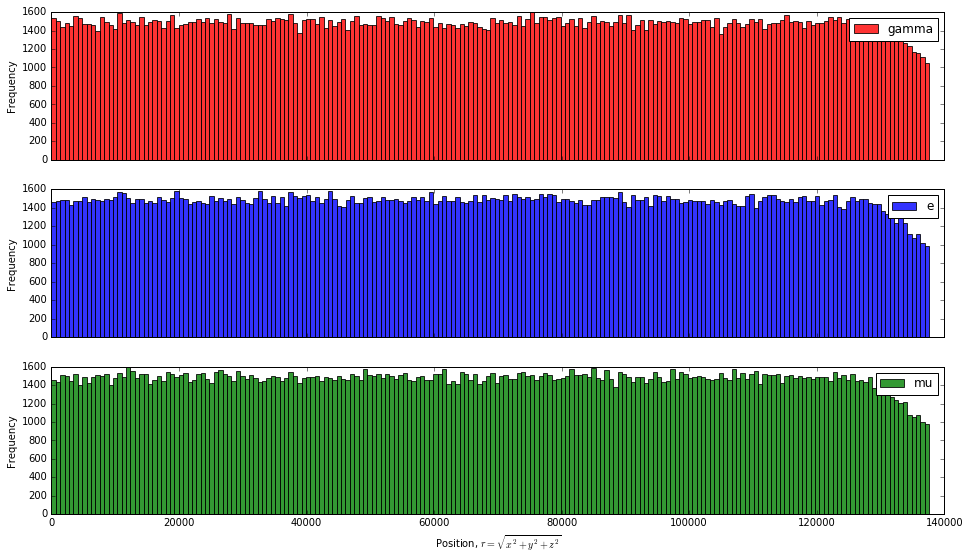

In [43]:
rs = np.array([position[0]**2 + position[2]**2 for position in raw_positions])

rs_dict = {}
for label in label_dict.keys():
    rs_dict[label] = rs[raw_labels == label]
    
fig, axes = plt.subplots(3, 1, figsize=(16,9), sharex=True)

for label in rs_dict.keys():
    axes[label].hist(rs_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend()
    axes[label].set_ylabel("Frequency")
    
plt.xlabel(r"Position, $r = \sqrt{x^2 + y^2 + z^2}$")

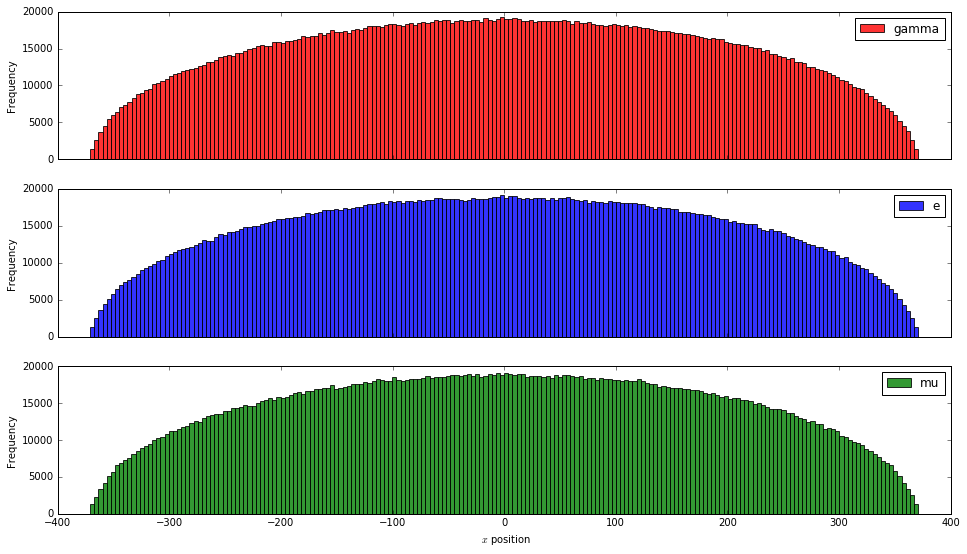

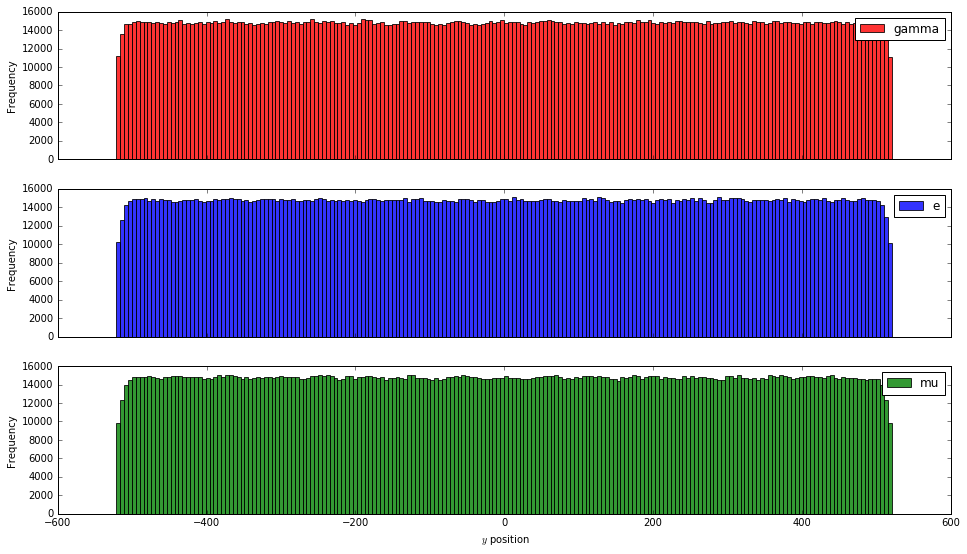

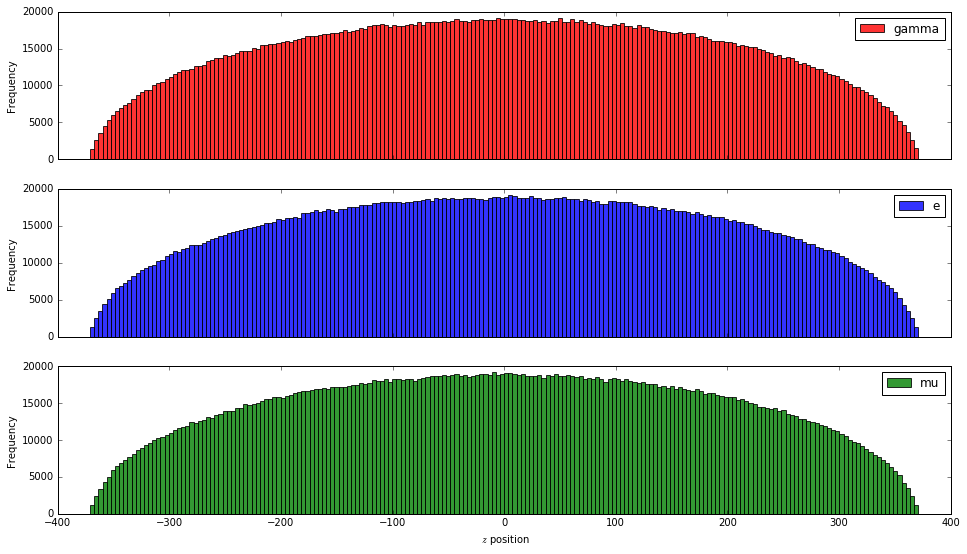

In [26]:
pos_x_dict = {}
pos_y_dict = {}
pos_z_dict = {}

for label in label_dict.keys():
    pos_x_dict[label] = raw_positions[raw_labels == label][:,0]
    pos_y_dict[label] = raw_positions[raw_labels == label][:,1]
    pos_z_dict[label] = raw_positions[raw_labels == label][:,2]

for pos_dict, axis in zip([pos_x_dict, pos_y_dict, pos_z_dict], ["x", "y", "z"]):
    fig, axes = plt.subplots(3, 1, figsize=(16,9), sharex=True)
    for label in label_dict.keys():
        axes[label].hist(pos_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                         color=label_dict[label][1])
        axes[label].legend()
        axes[label].set_ylabel("Frequency")
    plt.xlabel(r" ${0}$ position".format(axis))
    plt.show()